In [1]:
import numpy as np
import json
import os
import sys
import pandas as pd
import tarfile

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

from IPython.display import display, Image, HTML
import h5py

plt.rcParams['figure.figsize'] = (16.0, 4.0)
%matplotlib inline

In [2]:
from struct_extractor import DigitStructWrapper
# extracts the bounding box file and returns a dictionary
def get_bounding_boxes(start_path = '.'):
    return DigitStructWrapper(start_path).unpack_all()

# extract the bounding boxes
train_bbox = get_bounding_boxes('data/train/digitStruct.mat')
test_bbox = get_bounding_boxes('data/test/digitStruct.mat')
extra_bbox = get_bounding_boxes('data/extra/digitStruct.mat')

# display the information stored about an individual image
print(json.dumps(train_bbox[0], indent=2))

C:\Users\abhishek\Documents\struct_extractor.py:23: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
C:\Users\abhishek\Documents\struct_extractor.py:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])
C:\Users\abhishek\Documents\struct_extractor.py:25: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  attr = [attr.value[0][0]]


{
  "filename": "1.png",
  "boxes": [
    {
      "height": 219.0,
      "label": 1.0,
      "left": 246.0,
      "top": 77.0,
      "width": 81.0
    },
    {
      "height": 219.0,
      "label": 9.0,
      "left": 323.0,
      "top": 81.0,
      "width": 96.0
    }
  ]
}


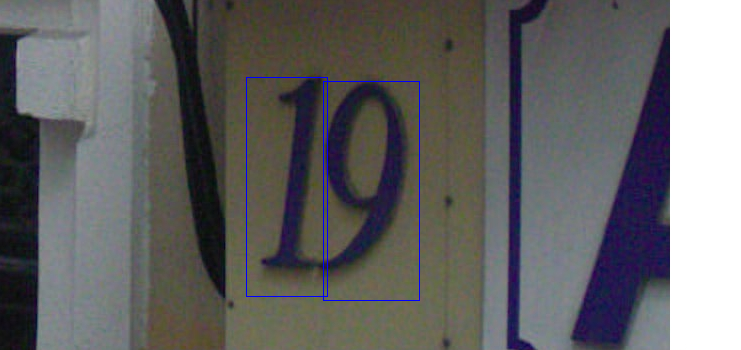

In [3]:
from PIL import Image, ImageDraw
#function to display some images with bbox's
def display_bounding_boxes(img, bounding_boxes):
    image = Image.open(img)
    draw = ImageDraw.Draw(image)
    for b in bounding_boxes:   
        # bounding box rectangle [x0, y0, x1, y1]
        rectangle = [b['left'], b['top'], b['left'] + b['width'], b['top'] + b['height']]   
        # draw rectangle on image
        draw.rectangle(rectangle, outline="blue")   
    # return drawn image    
    return image


# select 1 image and its corresponding box
image = 'data/train/1.png'
image_bounding_boxes = train_bbox[0]['boxes']
     
# display image along with bounding box
display_bounding_boxes(image, image_bounding_boxes)

In [4]:
#function for flattening the bounding box dictionary
def dict_to_dataframe(image_bounding_boxes, path):
    boxes = []
    # in each set of bounding boxes for every bounding box, store a dictionary with file and bounding box info
    for image in image_bounding_boxes:
        for bbox in image['boxes']:
            # store a dict with file and bounding box info
            boxes.append({
                    'filename': path + image['filename'],
                    'label': bbox['label'],
                    'width': bbox['width'],
                    'height': bbox['height'],
                    'top': bbox['top'],
                    'left': bbox['left']})
    # return the data as a DataFrame
    return pd.DataFrame(boxes)

bbox_file = 'data/bounding_boxes.csv'

if not os.path.isfile(bbox_file):
    # extract every individual bounding box as DataFrame  
    train_df = dict_to_dataframe(train_bbox, 'data/train/')
    test_df = dict_to_dataframe(test_bbox, 'data/test/')
    extra_df = dict_to_dataframe(extra_bbox, 'data/extra/')
    
    print("Training", train_df.shape)
    print("Test", test_df.shape)
    print("Extra", extra_df.shape)
    print('')

    # concatenate all the information in a single file
    df = pd.concat([train_df, test_df, extra_df])
    print("Combined", df.shape)
    # write dataframes to csv
    df.to_csv(bbox_file, index=False)
    # delete old dataframes
    del train_df, test_df, extra_df, train_bbox, test_bbox, extra_bbox
else:
    # load preprocessed bounding boxes
    df = pd.read_csv(bbox_file)
    
df.head()

Training (73257, 6)
Test (26032, 6)
Extra (531131, 6)

Combined (630420, 6)


,filename,label,width,height,top,left
0,data/train/1.png,1.0,81.0,219.0,77.0,246.0
1,data/train/1.png,9.0,96.0,219.0,81.0,323.0
2,data/train/2.png,2.0,23.0,32.0,29.0,77.0
3,data/train/2.png,3.0,26.0,32.0,25.0,98.0
4,data/train/3.png,2.0,8.0,15.0,5.0,17.0


In [5]:
# rename the columns
df.rename(columns={'left': 'x0', 'top': 'y0'}, inplace=True)
# calculate x1 and y1
df['x1'] = df['x0'] + df['width']
df['y1'] = df['y0'] + df['height']
# perform  following aggregations
aggregate = {'x0':'min',
             'y0':'min',
             'x1':'max',
             'y1':'max',
             'label':{
                'labels': lambda x: list(x),
                'num_digits': 'count'}}
df = df.groupby('filename').agg(aggregate).reset_index()

# fix the column names after aggregation
df.columns = [x[0] if i < 5 else x[1] for i, x in enumerate(df.columns.values)]
df.head()

c:\users\abhishek\appdata\local\programs\python\python36\lib\site-packages\pandas\core\groupby\generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


,filename,x0,y0,x1,y1,labels,num_digits
0,data/extra/1.png,24.0,23.0,126.0,126.0,"[4.0, 7.0, 8.0]",3
1,data/extra/10.png,5.0,5.0,52.0,32.0,"[4.0, 4.0, 4.0]",3
2,data/extra/100.png,3.0,1.0,46.0,30.0,"[5.0, 3.0, 5.0]",3
3,data/extra/1000.png,9.0,7.0,36.0,40.0,"[2.0, 6.0]",2
4,data/extra/10000.png,8.0,9.0,41.0,35.0,"[2.0, 10.0, 10.0]",3


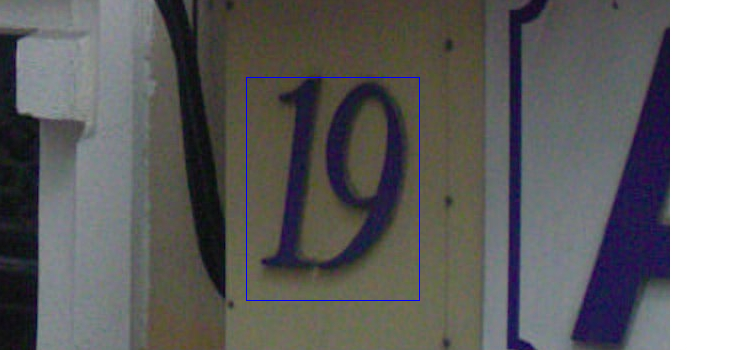

In [6]:
from PIL import Image, ImageDraw
# function to display a single image and bounding box
def display_bbox(image_path, bbox):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    draw.rectangle([bbox['x0'], bbox['y0'], bbox['x1'], bbox['y1']], outline="blue")
    return image

image = 'data/train/1.png'
bbox = df[df.filename == image]
display_bbox(image, bbox)

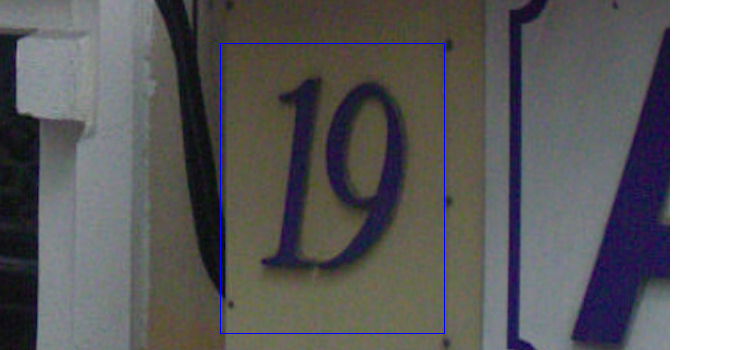

In [7]:
# calculate increase in x and y directions
df['x_increase'] = ((df['x1'] - df['x0']) * 0.3) / 2.
df['y_increase'] = ((df['y1'] - df['y0']) * 0.3) / 2.

# apply the increase in all four directions
df['x0'] = (df['x0'] - df['x_increase']).astype('int')
df['y0'] = (df['y0'] - df['y_increase']).astype('int')
df['x1'] = (df['x1'] + df['x_increase']).astype('int')
df['y1'] = (df['y1'] + df['y_increase']).astype('int')


# select the dataframe row corresponding to our image
image = 'data/train/1.png'
bbox = df[df.filename == image]

display_bbox(image, bbox)

In [8]:
# returns image size in pixels given (width, height)
def get_image_size(filepath):
    image = Image.open(filepath)
    return image.size 

# returns a DataFrame with the file name and size of all images contained in a folder
def get_image_sizes(folder):
    image_sizes = []
    # get all .png images contained in the folder
    images = [img for img in os.listdir(folder) if img.endswith('.png')]
    # get size of every image
    for image in images:
        w, h = get_image_size(folder + image)
        image_size = {'filename': folder + image, 'image_width': w, 'image_height': h}
        image_sizes.append(image_size)
        
    # return results as a pandas dataframe
    return pd.DataFrame(image_sizes)


# extract the image sizes
train_sizes = get_image_sizes('data/train/')
test_sizes = get_image_sizes('data/test/')
extra_sizes = get_image_sizes('data/extra/')

image_sizes = pd.concat([train_sizes, test_sizes, extra_sizes])
del train_sizes, test_sizes, extra_sizes
image_sizes.head(10)

,filename,image_width,image_height
0,data/train/1.png,741,350
1,data/train/10.png,74,37
2,data/train/100.png,67,27
3,data/train/1000.png,44,21
4,data/train/10000.png,137,62
5,data/train/10001.png,66,33
6,data/train/10002.png,295,117
7,data/train/10003.png,68,28
8,data/train/10004.png,95,41
9,data/train/10005.png,140,58


In [9]:
print("Bounding boxes", df.shape)
print("Image sizes", image_sizes.shape)
print('')

# inner join the datasets on filename
df = pd.merge(df, image_sizes, on='filename', how='inner')

print("Combined", df.shape)
del image_sizes
df.to_csv("data/image_data.csv", index=False)
df.head()

Bounding boxes (248823, 9)
Image sizes (248823, 3)

Combined (248823, 11)


,filename,x0,y0,x1,y1,labels,num_digits,x_increase,y_increase,image_width,image_height
0,data/extra/1.png,8,7,141,141,"[4.0, 7.0, 8.0]",3,15.30,15.45,166,141
1,data/extra/10.png,-2,0,59,36,"[4.0, 4.0, 4.0]",3,7.05,4.05,52,41
2,data/extra/100.png,-3,-3,52,34,"[5.0, 3.0, 5.0]",3,6.45,4.35,51,32
3,data/extra/1000.png,4,2,40,44,"[2.0, 6.0]",2,4.05,4.95,51,49
4,data/extra/10000.png,3,5,45,38,"[2.0, 10.0, 10.0]",3,4.95,3.90,55,44


In [10]:
# Correct bounding boxes not contained by image
df.loc[df['x0'] < 0, 'x0'] = 0
df.loc[df['y0'] < 0, 'y0'] = 0
df.loc[df['x1'] > df['image_width'], 'x1'] = df['image_width']
df.loc[df['y1'] > df['image_height'], 'y1'] = df['image_width']

df.head()

,filename,x0,y0,x1,y1,labels,num_digits,x_increase,y_increase,image_width,image_height
0,data/extra/1.png,8,7,141,141,"[4.0, 7.0, 8.0]",3,15.30,15.45,166,141
1,data/extra/10.png,0,0,52,36,"[4.0, 4.0, 4.0]",3,7.05,4.05,52,41
2,data/extra/100.png,0,0,51,51,"[5.0, 3.0, 5.0]",3,6.45,4.35,51,32
3,data/extra/1000.png,4,2,40,44,"[2.0, 6.0]",2,4.05,4.95,51,49
4,data/extra/10000.png,3,5,45,38,"[2.0, 10.0, 10.0]",3,4.95,3.90,55,44


In [11]:
#count number of images by the number of digits
df.num_digits.value_counts(sort=False)

1     17005
2     98212
3    117561
4     15918
5       126
6         1
Name: num_digits, dtype: int64

In [12]:
# discard image with 6 digits
df = df[df.num_digits < 6]

In [13]:
df[['image_width', 'image_height']].describe().round(decimals=2)

,image_width,image_height
count,248822.00,248822.00
mean,107.93,60.88
std,63.22,32.39
min,22.00,12.00
25%,69.00,40.00
50%,92.00,53.00
75%,127.00,74.00
max,1083.00,516.00


In [23]:
import cv2

#crop and resize an image
def crop_and_resize(image, img_size):
    image_data = cv2.imread(image['filename'])
    crop = image_data[image['y0']:image['y1'], image['x0']:image['x1'], :]
    return cv2.resize(crop, img_size)

#function for converting images into a numpy array
def create_dataset(df, img_size):
    # Initialize the numpy arrays (0's are stored as 10's)
    X = np.zeros(shape=(df.shape[0], img_size[0], img_size[0], 3), dtype='uint8')
    y = np.full((df.shape[0], 5), 10, dtype=int)
    
    # iterate over all images in the pandas dataframe (slow!)
    for i, (index, image) in enumerate(df.iterrows()):
        # get the image data and the label list as array
        X[i] = crop_and_resize(image, img_size)
        labels = np.array((image['labels']))       
        # store 0's as 0 (not 10)
        labels[labels==10] = 0
        # embed labels into label array
        y[i,0:labels.shape[0]] = labels
        
    # return data and labels   
    return X, y


# change this to select a different image size
image_size = (32, 32)

# get cropped images and labels
X_train, y_train = create_dataset(df[df.filename.str.contains('train')], image_size)
X_test, y_test = create_dataset(df[df.filename.str.contains('test')], image_size)
X_extra, y_extra = create_dataset(df[df.filename.str.contains('extra')], image_size)

del df

print("Training", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)
print('Extra', X_extra.shape, y_extra.shape)

Training (33401, 32, 32, 3) (33401, 5)
Test (13068, 32, 32, 3) (13068, 5)
Extra (202353, 32, 32, 3) (202353, 5)


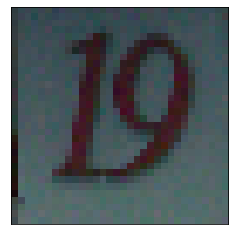

In [24]:
# plot cropped image
plt.imshow(X_train[0])
plt.xticks([]); plt.yticks([]);

In [25]:
# function for plotting nrows * ncols images
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        if cls_pred is None:
            title = "True: {0}".format(true_number)
        else:
            # string with predicted label
            pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
            title = "True: {0}, Pred: {1}".format(true_number, pred_number)  
        ax.imshow(images[i])
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

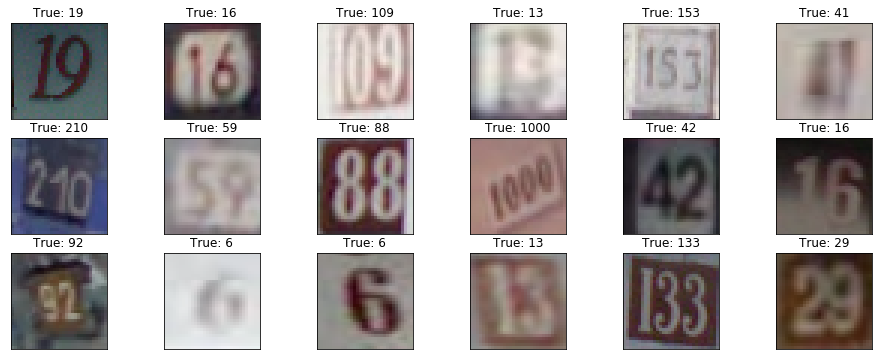

In [26]:
# display images from the training set
plot_images(X_train, 3, 6, y_train);

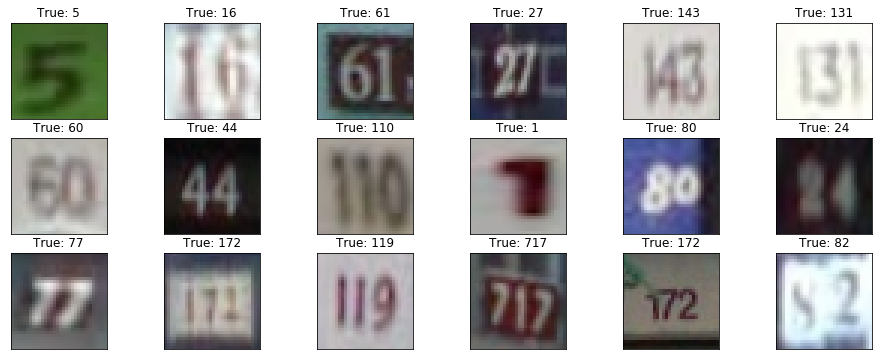

In [27]:
# display images from the test set
plot_images(X_test, 3, 6, y_test);

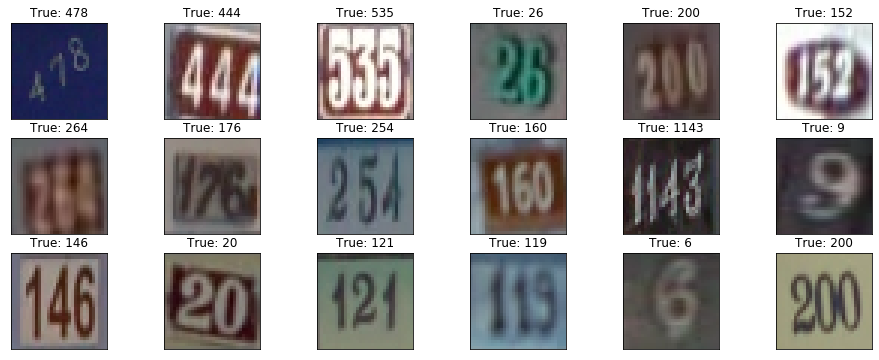

In [28]:
# display images from the extra set
plot_images(X_extra, 3, 6, y_extra);

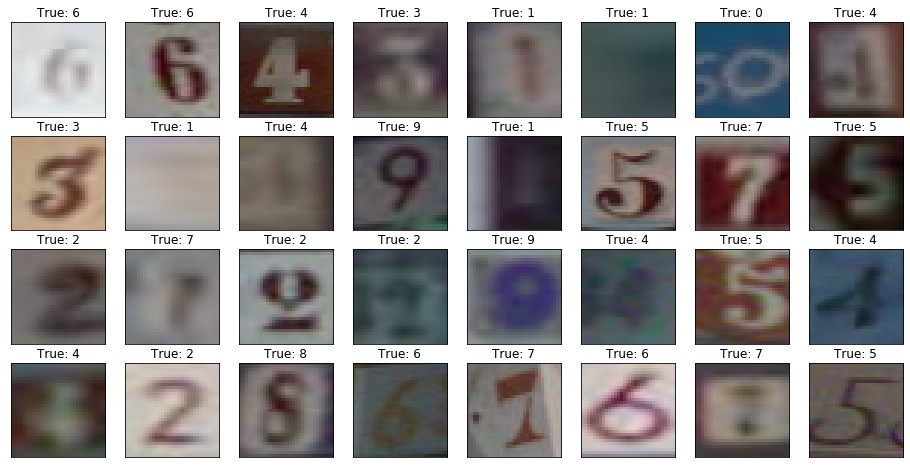

In [29]:
# find some images containing 1 digit
single_digit = (y_train != 10).sum(1) == 1

# display some exaples
plot_images(X_train[single_digit], 4, 8, y_train[single_digit]);

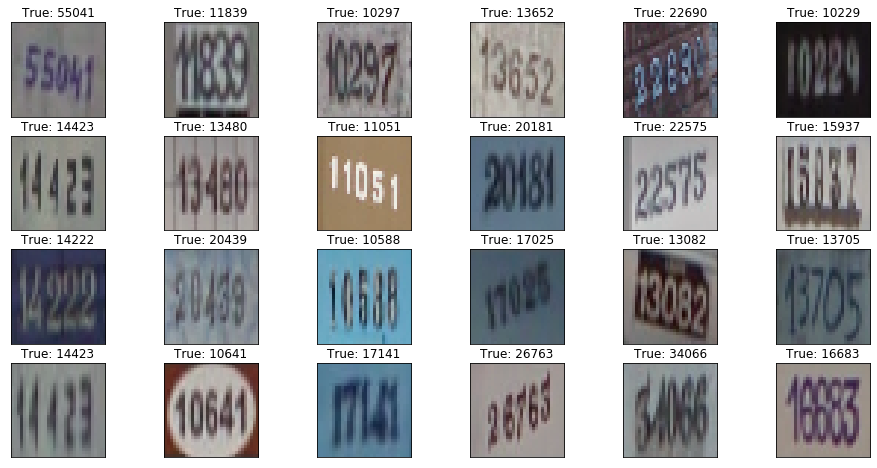

In [30]:
# find some images with five digits
five_digits = (y_extra != 10).sum(1) == 5

# display some examples 
plot_images(X_extra[five_digits], 4, 6, y_extra[five_digits]);

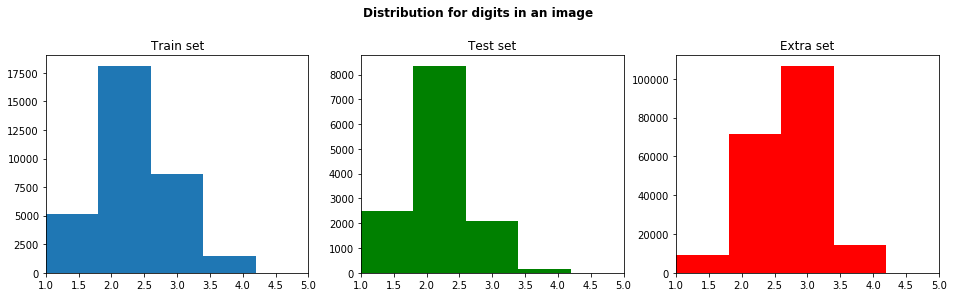

In [31]:
# initialize the subplotgrid
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(16, 4))

# set the main figure title
fig.suptitle('Distribution for digits in an image', fontsize=12, fontweight='bold', y=1.05)

# distribution training set 
ax1.hist((y_train != 10).sum(1), bins=5)
ax1.set_title("Train set");
ax1.set_xlim(1, 5)

# distribution test set 
ax2.hist((y_test != 10).sum(1), bins=5, color='g')
ax2.set_title("Test set");

# distribution extra set 
ax3.hist((y_extra != 10).sum(1), bins=5, color='r')
ax3.set_title("Extra set");

In [32]:
# return a boolean mask of size N with K selections
def random_sample(N, K):
    mask = np.array([True]*K + [False]*(N-K))
    np.random.shuffle(mask)
    return mask

# pick 5000 training and 2500 extra samples
sample1 = random_sample(X_train.shape[0], 5000)
sample2 = random_sample(X_extra.shape[0], 2500)

# create valdidation from sampled data
X_val = np.concatenate([X_train[sample1], X_extra[sample2]])
y_val = np.concatenate([y_train[sample1], y_extra[sample2]])

# keep the data not contained by sample
X_train = np.concatenate([X_train[~sample1], X_extra[~sample2]])
y_train = np.concatenate([y_train[~sample1], y_extra[~sample2]])

del X_extra, y_extra 

print("Training", X_train.shape, y_train.shape)
print('Validation', X_val.shape, y_val.shape)

Training (228254, 32, 32, 3) (228254, 5)
Validation (7500, 32, 32, 3) (7500, 5)


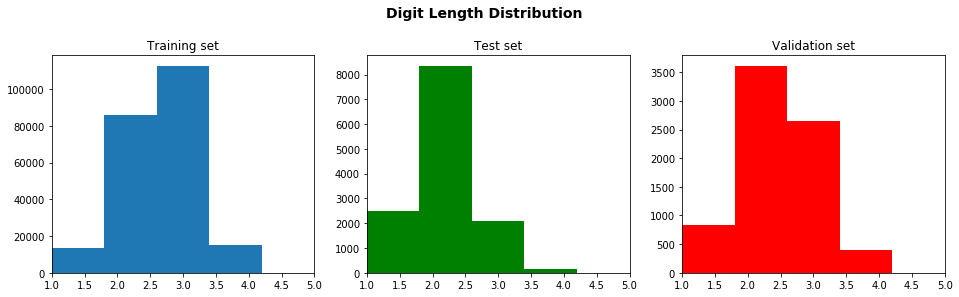

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(16, 4))

fig.suptitle('Digit Length Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist((y_train != 10).sum(1), bins=5)
ax1.set_title("Training set");
ax1.set_xlim(1, 5)

ax2.hist((y_test != 10).sum(1), bins=5, color='g')
ax2.set_title("Test set");

ax3.hist((y_val != 10).sum(1), bins=5, color='r')
ax3.set_title("Validation set");

In [38]:
# create h4f file
h5f = h5py.File('data/SVHN_rgb.h5', 'w')

# store datasets
h5f.create_dataset('train_dataset', data=X_train)
h5f.create_dataset('train_labels', data=y_train)
h5f.create_dataset('test_dataset', data=X_test)
h5f.create_dataset('test_labels', data=y_test)
h5f.create_dataset('validation_dataset', data=X_val)
h5f.create_dataset('validation_labels', data=y_val)

h5f.close()

In [ ]:
def rgb2gray(images):
    greyscale = np.dot(images, [0.2989, 0.5870, 0.1140])
    return np.expand_dims(greyscale, axis=3)


# transform the images to grayscale
X_train = rgb2gray(X_train).astype(np.float32)
X_test = rgb2gray(X_test).astype(np.float32)
X_val = rgb2gray(X_val).astype(np.float32)

In [ ]:
# Create file
h5f = h5py.File('data/SVHN_gray.h5', 'w')

# store datasets
h5f.create_dataset('train_dataset', data=X_train)
h5f.create_dataset('train_labels', data=y_train)
h5f.create_dataset('test_dataset', data=X_test)
h5f.create_dataset('test_labels', data=y_test)
h5f.create_dataset('validation_dataset', data=X_val)
h5f.create_dataset('validation_labels', data=y_val)

h5f.close()